# HousingPrices
Implement from scratch the ridge regression algorithm for regression with square loss.

Apply the algorithm to the prediction of the label medianHouseValue in this dataset.

Study the dependence of the cross-validated risk estimate on the parameter alpha of ridge regression.

Try using PCA to improve the risk estimate.

Optionally, use nested cross-validated risk estimates to remove the need of choosing the parameter.

Here is a description of the attributes in the dataset:
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

Note: The dataset has an attribute with missing values and an attribute with categorical values. Find a way of handling these anomalies and justify your choice.


## License
Copyright 2020 (c) Anna Olena Zhab'yak, Michele Maione. All rights reserved.

Licensed under the [MIT](LICENSE) License.

----------------
# Ridge regression
This is a regression technique wich allows to deal with the multicollinearity of the features and try to reduce the overfitting of the data. 
minimize two elements, the RSS and the objective function 

In ridge regression two elements are optimized , the RSS and the objective function

$ \lVert y - Xw \rVert ^2_2 + \alpha \lVert w \rVert^2_2 $

It is a variation of the Linear regression with a tunning parameter alpha to control model complexity.
need to do a trade off between variance and bias
1. the inhability for the model to capture the true relationship is called bias. How well the model fits our data 
2. how well model does on a completely new dataset. 

use the hyper parameter called alpha , to add a bias , prevent the model from real, it will have better accurancy on the testing set, it means it will not overfit in the training set.  

## Libraries 

For this analysis, we will use a few libraries for managing and transform the database as well as to implement the ridge regression. First, let's download the libraries 

In [1]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, train_test_split, KFold, GridSearchCV

from svd import SVD
from lsqr import LSQR
from cholesky import Cholesky

----------------
## Dataset analysis
Open the database, check the structure, show the head, take a look of its structure, the descriptive statistics and manage the columns.

Create the constants

The target value is the median_house_value which is predicted based on the features of different houses.

### Mean squared error
The mean squared error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

### R²
The coefficient R² is defined as $ 1 - {u \over v} $, where u is the residual sum of squares $ \sum (y - y')^2 $ and v is the total sum of squares $ \sum (y - \bar{y})^2 $.

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

In [2]:
RMS = 'neg_mean_squared_error'
R2 = 'r2'

#scoring = R2
#scoring_neg = 1
#scoring_label = 'R²'

scoring = RMS
scoring_neg = -1
scoring_label = 'MSE'

In [3]:
nested_cross_validation_trials = 10

fit_intercept = True
normalize = True

shuffleDataSet = False

cpu = -1

Valori di ɑ usati

In [4]:
alphas = numpy.linspace(1e-5, 1, 20)
alphas

array([1.00000000e-05, 5.26410526e-02, 1.05272105e-01, 1.57903158e-01,
       2.10534211e-01, 2.63165263e-01, 3.15796316e-01, 3.68427368e-01,
       4.21058421e-01, 4.73689474e-01, 5.26320526e-01, 5.78951579e-01,
       6.31582632e-01, 6.84213684e-01, 7.36844737e-01, 7.89475789e-01,
       8.42106842e-01, 8.94737895e-01, 9.47368947e-01, 1.00000000e+00])

Create the constants

In [5]:
column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [6]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')

# shuffle all DB
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

In [7]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [8]:
data_frame.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
data_frame.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-117.99,33.88,25.0,3401.0,509.0,1503.0,498.0,6.6704,240600.0,<1H OCEAN
1,-117.64,34.07,38.0,2450.0,544.0,1823.0,536.0,2.8370,111200.0,INLAND
2,-119.35,36.22,32.0,1290.0,304.0,852.0,309.0,1.4429,54600.0,INLAND
3,-119.62,37.33,7.0,3389.0,621.0,1268.0,474.0,3.0224,147800.0,INLAND
4,-122.26,37.77,52.0,1704.0,371.0,663.0,340.0,4.2260,275000.0,NEAR BAY


Here is the distribution of the values of the target variable "median_house_value".
It looks like a normal distribution with a group of outliers on the highest value of the house.

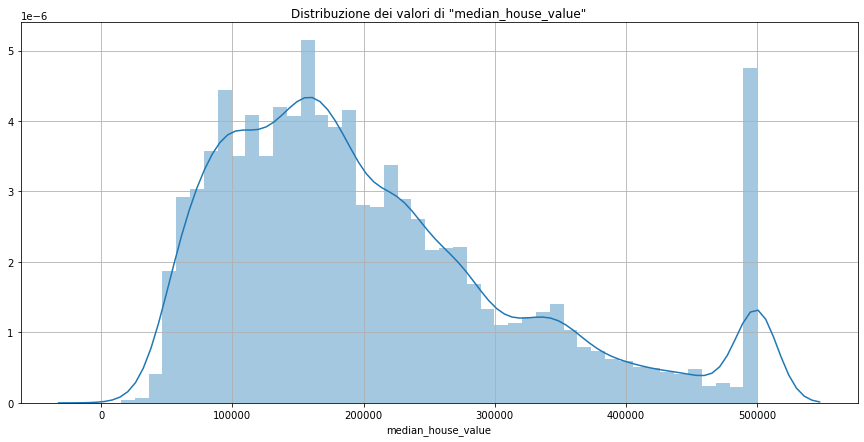

In [10]:
plt.figure(figsize=(15, 7))
plt.title('Distribuzione dei valori di "median_house_value"')

seaborn.distplot(data_frame[column_to_predict])

plt.grid()
plt.show()

----------------
## Data pre-processing

### Outliers

In [11]:
outliers = data_frame[data_frame[column_to_predict] == 500001].index

print(f'There are {len(outliers)} outliers')

data_frame.drop(outliers, inplace=True)

There are 965 outliers


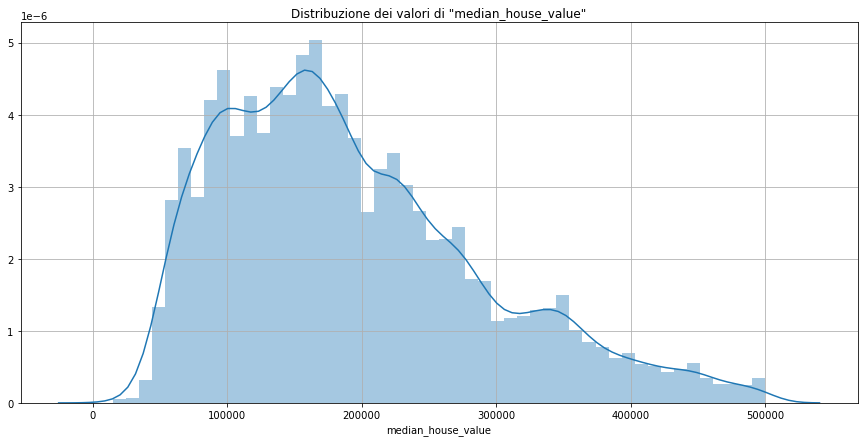

In [12]:
plt.figure(figsize=(15, 7))
plt.title('Distribuzione dei valori di "median_house_value"')

seaborn.distplot(data_frame[column_to_predict])

plt.grid()
plt.show()

###  Missing values
The dataset contains missing values which are handeled by replacing the value with the mean value of the column. This procedure is necessary to avoid errors in the execution.

In [13]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)

### Categorical feature
Categorical values cannot be treated as such for the statistical analysis, therefore they must be transormed in numbers.

In [14]:
labelencoder = LabelEncoder()

for c in categories_columns:
    c_name = c + '_cat'
    data_frame[c_name] = labelencoder.fit_transform(data_frame[c])
    numerics_columns.append(c_name)
    
data_frame.drop(columns=categories_columns, inplace=True)

### Correlation of the dataset
Explore the Peasrson's coefficient of correlation and build a simmetric correlation matrix between the features. This procedure is helpeful to eventually reduce the dimension of the dataset. 

Equazioni esempio:

$$ \hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j}  $$

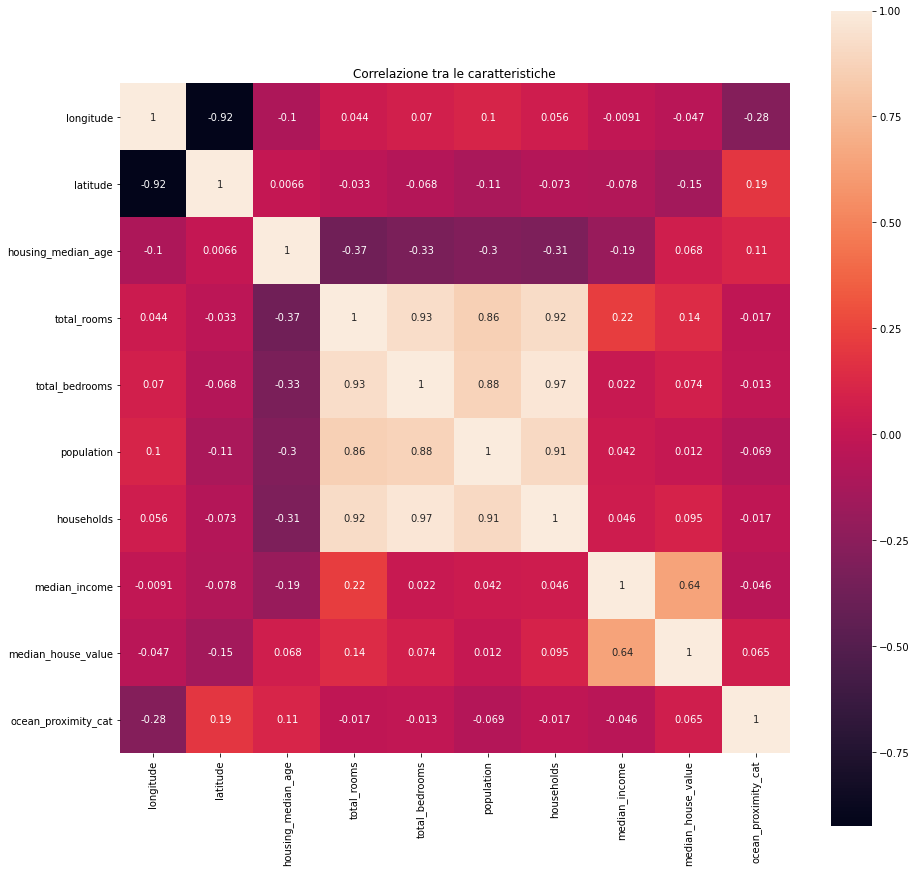

In [15]:
corr = data_frame.corr()

plt.figure(figsize=(15, 15))
plt.title('Correlazione tra le caratteristiche')

seaborn.heatmap(corr, square=True, annot=True)

plt.show()

Pearson's coefficient is determined by :

$$ r_{i,j} = \frac{\sum_{t=1}^m (x_{i,t}-\mu_i)(x_{j,t}-\mu_j)}{\sqrt{\sum_{t=1}^m (x_{i,t}-\mu_i)^2}\sqrt{\sum_{t=1}^m (x_{j,t}-\mu_j)^2}} $$

The coefficient is in between -1 and +1, when it is close to |1| then there is a correlation (positive or negative) otherwise if the coefficient is close to 0 there isn't any correlation. If some features are linearly correlated they are not useful, because we can explain one feature through the correlated one.

In [16]:
correlated_features = corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)].dropna(axis='index', how='all')
correlated_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_cat
longitude,NaN,-0.924139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.930916,0.859590,0.921102,NaN,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.930916,NaN,0.875270,0.974006,NaN,NaN,NaN
population,NaN,NaN,NaN,0.859590,0.875270,NaN,0.908997,NaN,NaN,NaN
households,NaN,NaN,NaN,0.921102,0.974006,0.908997,NaN,NaN,NaN,NaN


As we can see the pairs of the most correlated features are 
(households - total_bedrooms)
(population - housegìholds)
(total_rooms - total_bedrooms)
(total_bedroom - households)

Delete the correlated features
1. latitude
2. population 
3. total_rooms

In [17]:
#columns_to_remove = ['latitude', 'population', 'total_rooms']
columns_to_remove = []
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)
        
data_frame.drop(columns=columns_to_remove, inplace=True)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

Quindi la nostra attuale X è la seguente:

In [18]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_cat
0,-117.99,33.88,25.0,3401.0,509.0,1503.0,498.0,6.6704,0
1,-117.64,34.07,38.0,2450.0,544.0,1823.0,536.0,2.8370,1
2,-119.35,36.22,32.0,1290.0,304.0,852.0,309.0,1.4429,1
3,-119.62,37.33,7.0,3389.0,621.0,1268.0,474.0,3.0224,1
4,-122.26,37.77,52.0,1704.0,371.0,663.0,340.0,4.2260,3
...,...,...,...,...,...,...,...,...,...
20635,-117.85,33.74,19.0,1248.0,357.0,1214.0,328.0,2.7059,0
20636,-119.02,35.42,40.0,1089.0,226.0,520.0,218.0,2.2727,1
20637,-117.95,33.78,32.0,2296.0,560.0,1376.0,532.0,3.7303,0
20638,-117.02,32.76,40.0,2523.0,488.0,976.0,470.0,3.1100,0


Quindi la nostra attuale y è la seguente:

In [19]:
y

0        240600.0
1        111200.0
2         54600.0
3        147800.0
4        275000.0
           ...   
20635    159800.0
20636     67200.0
20637    188500.0
20638    185700.0
20639    260900.0
Name: median_house_value, Length: 19675, dtype: float64

----------------
## Scaler
Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

This transformation is often used as an alternative to zero mean, unit variance scaling.

In [20]:
useMinMaxScaler = True

if useMinMaxScaler:
    column_to_predict_idx = data_frame.columns.get_loc(column_to_predict)
    cols = list(range(0, data_frame.shape[1]))
    cols.remove(column_to_predict_idx)

    scaler = MinMaxScaler()
    scaler.fit(data_frame)
    data_frame = scaler.transform(data_frame)

    X = data_frame[:, cols]
    y = data_frame[:, column_to_predict_idx]

In [21]:
data_frame = pandas.DataFrame(data_frame, columns=columns_to_use)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

In [22]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_cat
0,0.633466,0.142402,0.470588,0.086449,0.078690,0.042042,0.081579,0.425546,0.00
1,0.668327,0.162593,0.725490,0.062262,0.084122,0.051010,0.087829,0.161177,0.25
2,0.498008,0.391073,0.607843,0.032759,0.046873,0.023796,0.050493,0.065034,0.25
3,0.471116,0.509033,0.117647,0.086144,0.096073,0.035455,0.077632,0.173963,0.25
4,0.208167,0.555792,1.000000,0.043288,0.057271,0.018498,0.055592,0.256969,0.75
...,...,...,...,...,...,...,...,...,...
19670,0.647410,0.127524,0.352941,0.031690,0.055099,0.033942,0.053618,0.152136,0.00
19671,0.530876,0.306057,0.764706,0.027646,0.034766,0.014490,0.035526,0.122260,0.25
19672,0.637450,0.131775,0.607843,0.058345,0.086606,0.038482,0.087171,0.222783,0.00
19673,0.730080,0.023379,0.764706,0.064118,0.075431,0.027271,0.076974,0.180004,0.00


In [23]:
y

0        0.465156
1        0.198352
2        0.081651
3        0.273816
4        0.536083
           ...   
19670    0.298558
19671    0.107631
19672    0.357733
19673    0.351960
19674    0.507011
Name: median_house_value, Length: 19675, dtype: float64

----------------
## Learning algorithm
Before starting to learn the algorithm, the dataset must be splitted in subsets in order to preserve some data for the validation of the method.

In [24]:
svd = SVD()
lsqr = LSQR()
cholesky = Cholesky()

### Train & Test
Train 60%, Test 40%

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=shuffleDataSet)

### Elaborazione per range di ɑ

In [26]:
maes_c = []
maes_s = []

r2s_c = []
r2s_s = []

for ɑ in alphas:
    cholesky.alpha = ɑ
    svd.alpha = ɑ

    cholesky.fit(x_train, y_train)
    svd.fit(x_train, y_train)
    
    y_predict_c = cholesky.predict(x_test)
    y_predict_s = svd.predict(x_test)

    # Return the MSE of the prediction.
    mae_c = mean_squared_error(y_test, y_predict_c)
    mae_s = mean_squared_error(y_test, y_predict_s)
    
    maes_c.append(mae_c)
    maes_s.append(mae_s)
    
    r2_c = r2_score(y_test, y_predict_c)
    r2_s = r2_score(y_test, y_predict_s)
    
    r2s_c.append(r2_c)
    r2s_s.append(r2_s)

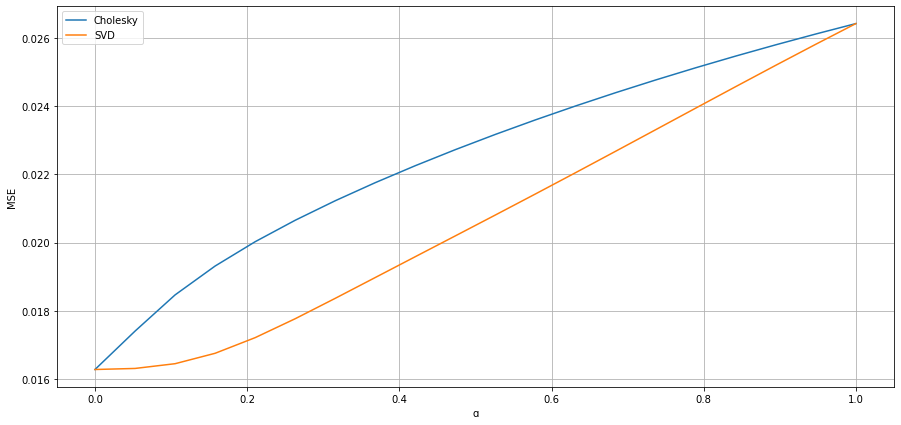

In [27]:
plt.figure(figsize=(15, 7))

plt.plot(alphas, maes_c, label='Cholesky')
plt.plot(alphas, maes_s, label='SVD')

plt.xlabel("ɑ")
plt.ylabel("MSE")

plt.legend()
plt.grid()
plt.show()

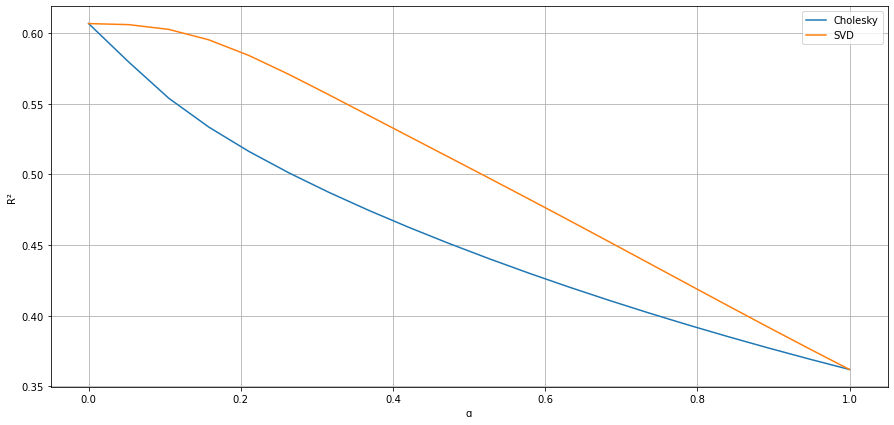

In [28]:
plt.figure(figsize=(15, 7))

plt.plot(alphas, r2s_c, label='Cholesky')
plt.plot(alphas, r2s_s, label='SVD')

plt.xlabel("ɑ")
plt.ylabel("R²")

plt.legend()
plt.grid()
plt.show()

In [29]:
idx_max_r2_c = numpy.argmax(r2s_c)
idx_max_r2_s = numpy.argmax(r2s_s)

idx_max_mae_c = numpy.argmax(maes_c)
idx_max_mae_s = numpy.argmax(maes_s)

best_alpha_c = alphas[idx_max_r2_c]
best_alpha_s = alphas[idx_max_r2_s]

print('Cholesky:')
print(f'-best ɑ: {best_alpha_c}')
print(f'-best MAE: {maes_c[idx_max_mae_c]}')
print(f'-best R²: {r2s_c[idx_max_r2_c]}')

print('SVD:')
print(f'-best ɑ: {best_alpha_s}')
print(f'-best MAE: {maes_s[idx_max_mae_s]}')
print(f'-best R²: {r2s_s[idx_max_r2_s]}')

Cholesky:
-best ɑ: 1e-05
-best MAE: 0.02641477047814201
-best R²: 0.6067775031784847
SVD:
-best ɑ: 1e-05
-best MAE: 0.02641477047814204
-best R²: 0.6067797338917644


In [30]:
cholesky.alpha = best_alpha_c
svd.alpha = best_alpha_c

cholesky.fit(x_train, y_train)
svd.fit(x_train, y_train)

y_predict_c = cholesky.predict(x_test)
y_predict_s = svd.predict(x_test)

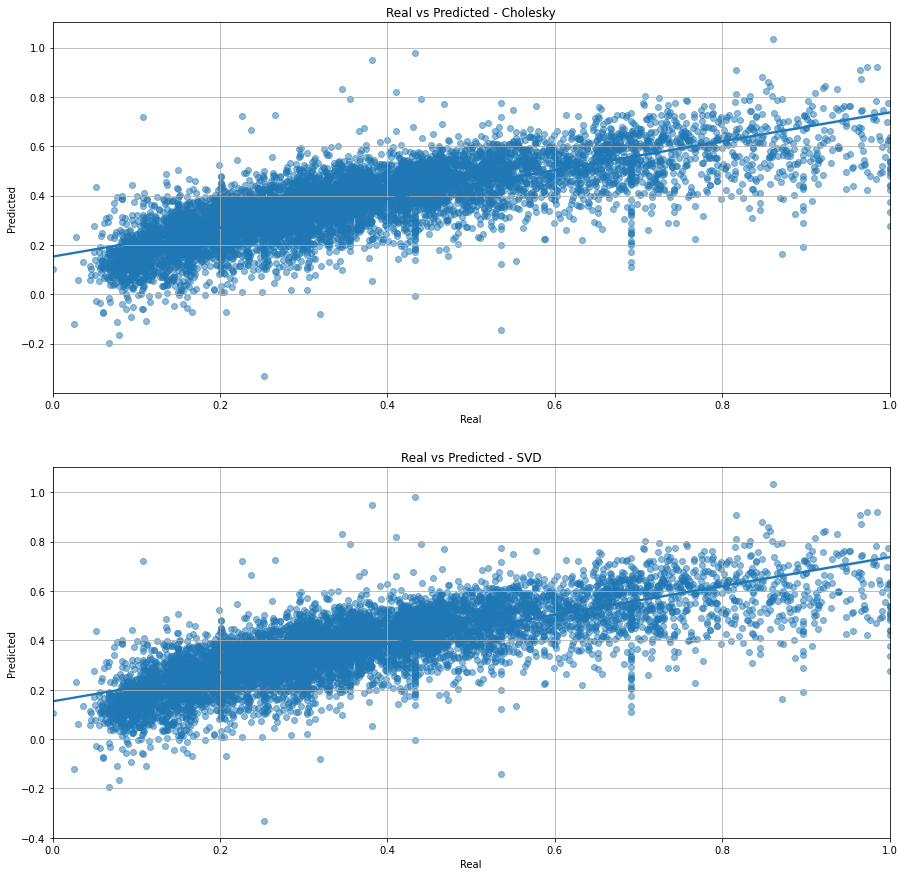

In [31]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

ax1.set_title('Real vs Predicted - Cholesky')
ax2.set_title('Real vs Predicted - SVD')

seaborn.regplot(y_test, y_predict_c, scatter_kws={'alpha':0.5}, ax=ax1)
seaborn.regplot(y_test, y_predict_s, scatter_kws={'alpha':0.5}, ax=ax2)

ax1.set_xlabel('Real')
ax1.set_ylabel('Predicted')

ax2.set_xlabel('Real')
ax2.set_ylabel('Predicted')

ax1.grid()
ax2.grid()

plt.show()

----------------
## Cross-validation

### Cross-validated risk estimate
Cross Validation is is a method that allows to perform selection and  validation of the learning algorithm. 

Set aside a portion of the data for the test set and perform multiple interations on the training data, splitted in k-folds and validate the hyperparameter to one fold per time . Then compare to the test data.

Method for comparing is the root mean squared error.

Normalize to get values normalized

Use the 5-fold cross validation

#### K-Folds cross-validator
Provides train/test indices to split data in train/test sets.

Split dataset into k consecutive folds (without shuffling by default).

Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [32]:
scores_c = []
scores_s = []

kf = KFold(n_splits=5, shuffle=shuffleDataSet)

for ɑ in alphas:
    k_scores_c = []
    k_scores_s = []
    
    cholesky.alpha = ɑ
    svd.alpha = ɑ
    
    for train_index, test_index in kf.split(X):
        x_train, x_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                
        cholesky.fit(x_train, y_train)
        svd.fit(x_train, y_train)

        y_pred_c = cholesky.predict(x_test)
        y_pred_s = svd.predict(x_test)
        
        # Return the coefficient of determination R² of the prediction.
        score_c = r2_score(y_test, y_pred_s)
        score_s = r2_score(y_test, y_pred_c)

        k_scores_c.append(score_c)
        k_scores_s.append(score_s)
        
    scores_c.append(numpy.mean(k_scores_c))
    scores_s.append(numpy.mean(k_scores_s))

In [33]:
idx_max_c = numpy.argmax(scores_c)
idx_max_s = numpy.argmax(scores_s)

best_alpha_c = alphas[idx_max_c]
best_alpha_s = alphas[idx_max_s]

print(f'Cholesky best ɑ: {best_alpha_c}')
print(f'Cholesky best score: {scores_c[idx_max_c]}')

print(f'SVD best ɑ: {best_alpha_s}')
print(f'SVD best score: {scores_s[idx_max_s]}')

Cholesky best ɑ: 1e-05
Cholesky best score: 0.596590889135774
SVD best ɑ: 1e-05
SVD best score: 0.5965914545627987


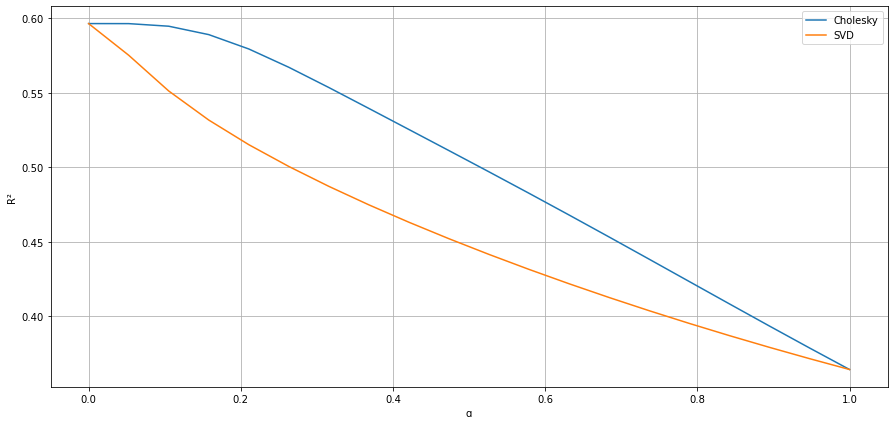

In [34]:
plt.figure(figsize=(15, 7))
plt.xlabel('ɑ')
plt.ylabel('R²')

plt.plot(alphas, scores_c, label='Cholesky')
plt.plot(alphas, scores_s, label='SVD')

plt.legend()
plt.grid()
plt.show()

In [35]:
idx_max_c = numpy.argmax(scores_c)
idx_max_s = numpy.argmax(scores_s)

if best_alpha_c == alphas[idx_max_c]:
    print('Il valore di ɑ per Cholesky è invariato!')
else:    
    best_alpha_c = alphas[idx_max_c]
    print(f'Cholesky best ɑ: {best_alpha_c}')

if best_alpha_s == alphas[idx_max_s]:
    print('Il valore di ɑ per SVD è invariato!')
else:    
    best_alpha_s = alphas[idx_max_s]
    print(f'SVD best ɑ: {best_alpha_s}')

Il valore di ɑ per Cholesky è invariato!
Il valore di ɑ per SVD è invariato!


In [36]:
if best_alpha_c != alphas[idx_max_c]:
    cholesky.set_params(alpha = best_alpha_c)
    cholesky.fit(x_train, y_train, best_alpha_c)
    y_predict_c = cholesky.predict(x_test)
    score_c = mean_squared_error(y_predict_c, y_test)    
    print(f'Cholesky score: {score_c}')

if best_alpha_s != alphas[idx_max_s]:
    svd.set_params(alpha = best_alpha_s)
    svd.fit(x_train, y_train, best_alpha_s)
    y_predict_s = svd.predict(x_test)
    score_s = mean_squared_error(y_predict_s, y_test)
    print(f'SVD score: {score_s}')

In [37]:
if best_alpha_c != alphas[idx_max_c] or best_alpha_s != alphas[idx_max_s]:
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

    ax1.set_title('Real vs Predicted - Cholesky')
    ax2.set_title('Real vs Predicted - SVD')

    seaborn.regplot(y_predict_c, y_test, scatter_kws={'alpha':0.5}, ax=ax1)
    seaborn.regplot(y_predict_s, y_test, scatter_kws={'alpha':0.5}, ax=ax2)

    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Real')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Real')

    ax1.grid()
    ax2.grid()

    plt.show()

----------------
## Nested cross-validation

### GridSearchCV
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [38]:
p_grid = {"alpha": alphas}

non_nested_scores = numpy.zeros(nested_cross_validation_trials)
nested_scores = numpy.zeros(nested_cross_validation_trials)

for i in range(nested_cross_validation_trials):
    # Choose cross-validation techniques for the inner and outer loops, independently of the dataset
    inner_cv = KFold(n_splits=5, shuffle=shuffleDataSet)
    outer_cv = KFold(n_splits=5, shuffle=shuffleDataSet)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svd, param_grid=p_grid, cv=inner_cv, n_jobs=cpu)
    clf.fit(X, y)
    
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv, n_jobs=cpu)
    nested_scores[i] = nested_score.mean()

In [39]:
score_difference = non_nested_scores - nested_scores
print("Average difference of {:6f} with std. dev. of {:6f}.".format(score_difference.mean(), score_difference.std()))

Average difference of 0.000000 with std. dev. of 0.000000.


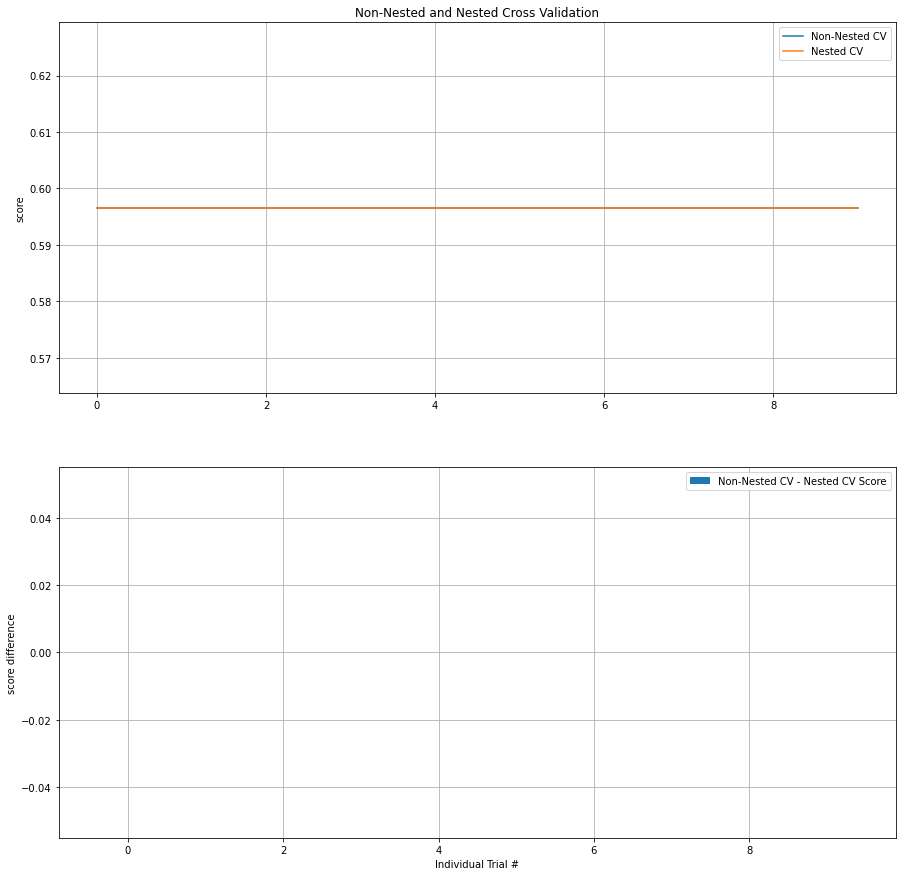

In [40]:
# Plot scores on each trial for nested and non-nested CV
plt.figure(figsize=(15, 15))
plt.subplot(211)

non_nested_scores_line, = plt.plot(non_nested_scores)
nested_line, = plt.plot(nested_scores)

plt.ylabel("score")
plt.grid()
plt.legend([non_nested_scores_line, nested_line], ["Non-Nested CV", "Nested CV"])
plt.title("Non-Nested and Nested Cross Validation")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(nested_cross_validation_trials), score_difference)

plt.xlabel("Individual Trial #")

plt.grid()
plt.legend([difference_plot], ["Non-Nested CV - Nested CV Score"])
plt.ylabel("score difference")

plt.show()

----------------
## Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

In [41]:
min_ts = int(X.shape[0] * 0.1)
max_ts = int(X.shape[0] * 0.8)
step_ts = int(X.shape[0] * 0.05)
sizes = range(min_ts, max_ts, step_ts)

print(sizes)

range(1967, 15740, 983)


In [42]:
coef_list = []

cholesky.alpha = best_alpha_c

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=shuffleDataSet)
    cholesky.fit(X_train, y_train)
    coef_list.append(cholesky.coef_)

coef_matrix = numpy.array(coef_list)

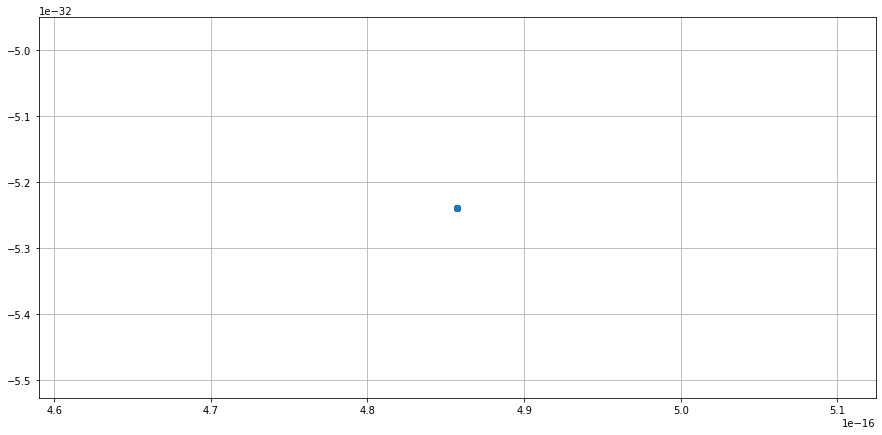

In [43]:
pca = PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

plt.figure(figsize=(15, 7))
plt.grid()
plt.scatter(coef_pca[:,0], coef_pca[:,1])
plt.show()

In [44]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)

X_pca = pca.transform(X)

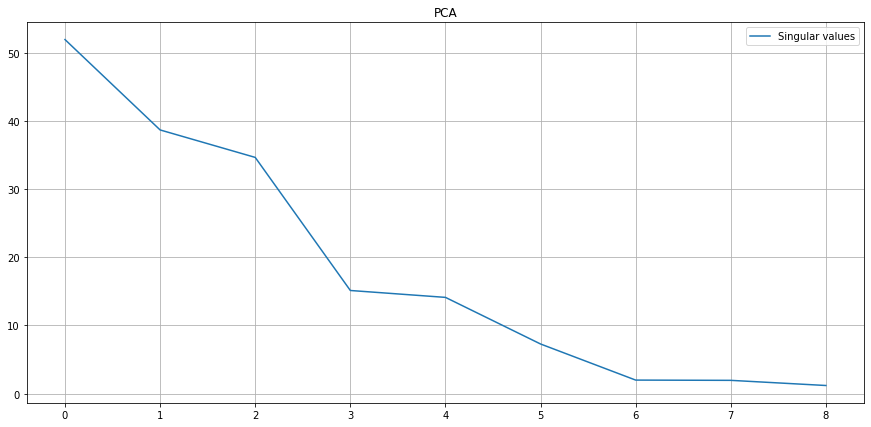

In [45]:
plt.figure(figsize=(15, 7))
plt.title('PCA')

plt.plot(pca.singular_values_, label='Singular values')

plt.grid()
plt.legend()
plt.show()

We project all the datapoints on the five principal components. Then we check the learning curve again.

In [46]:
pca = PCA(n_components=5)
pca.fit(X)

X_pca = pca.transform(X)

# Returns:
# -Numbers of training examples that has been used to generate the learning curve. Note that the number of ticks might be less than n_ticks because duplicate entries will be removed;
# -Scores on training sets;
# -Scores on test set.
train_size, train_score, val_score = learning_curve(cholesky, X_pca, y, train_sizes=sizes, cv=5, scoring=scoring, n_jobs=cpu)

train_score_mean = scoring_neg * numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = scoring_neg * numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

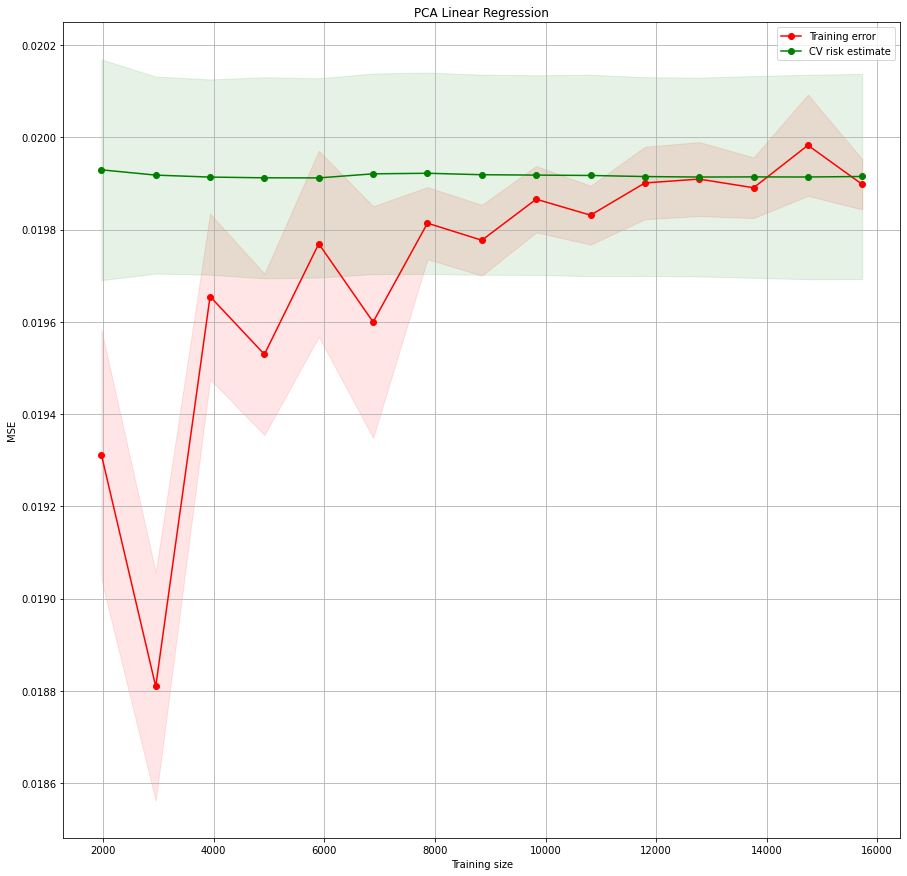

In [47]:
plt.figure(figsize=(15, 15))
plt.title('PCA Linear Regression')

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, alpha=0.1, color="r")
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, alpha=0.1, color="g")

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training error")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="CV risk estimate")

plt.xlabel('Training size')
plt.ylabel(scoring_label)

plt.grid()
plt.legend()
plt.show()

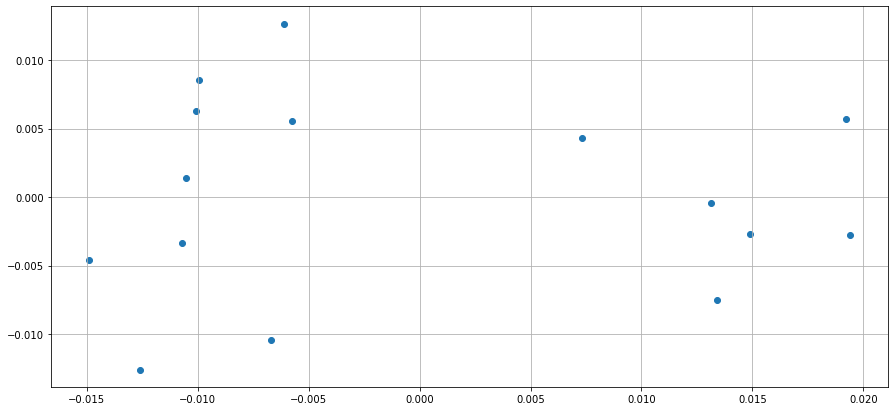

In [48]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, shuffle=shuffleDataSet)
    cholesky.fit(X_train, y_train)
    coef_list.append(cholesky.coef_)
    
coef_matrix = numpy.array(coef_list)

pca = PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

plt.figure(figsize=(15, 7))
plt.grid()
plt.scatter(coef_pca[:,0], coef_pca[:,1])
plt.show()

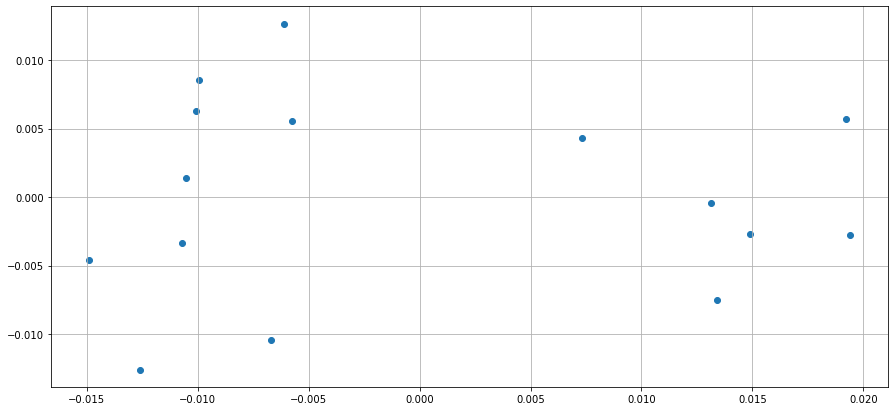

In [49]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, shuffle=shuffleDataSet)
    cholesky.fit(X_train, y_train)
    coef_list.append(cholesky.coef_)
    
coef_matrix = numpy.array(coef_list)

pca = PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

plt.figure(figsize=(15, 7))
plt.grid()
plt.scatter(coef_pca[:,0], coef_pca[:,1])
plt.show()

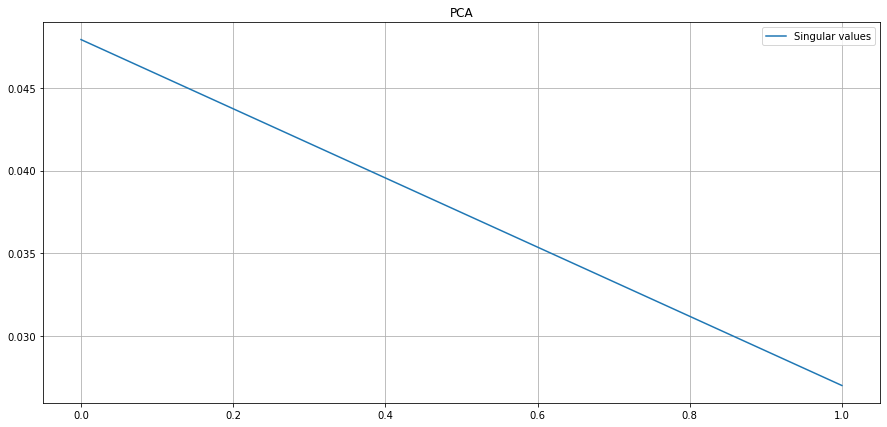

In [50]:
plt.figure(figsize=(15, 7))
plt.title('PCA')

plt.plot(pca.singular_values_, label='Singular values')

plt.grid()
plt.legend()
plt.show()

We project all the datapoints on the five principal components. Then we check the learning curve again.

In [51]:
pca = PCA(n_components=5)
pca.fit(X)

X_pca = pca.transform(X)

# Returns:
# -Numbers of training examples that has been used to generate the learning curve. Note that the number of ticks might be less than n_ticks because duplicate entries will be removed;
# -Scores on training sets;
# -Scores on test set.
train_size, train_score, val_score = learning_curve(cholesky, X_pca, y, train_sizes=sizes, cv=5, scoring=scoring, n_jobs=cpu)

train_score_mean = scoring_neg * numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = scoring_neg * numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

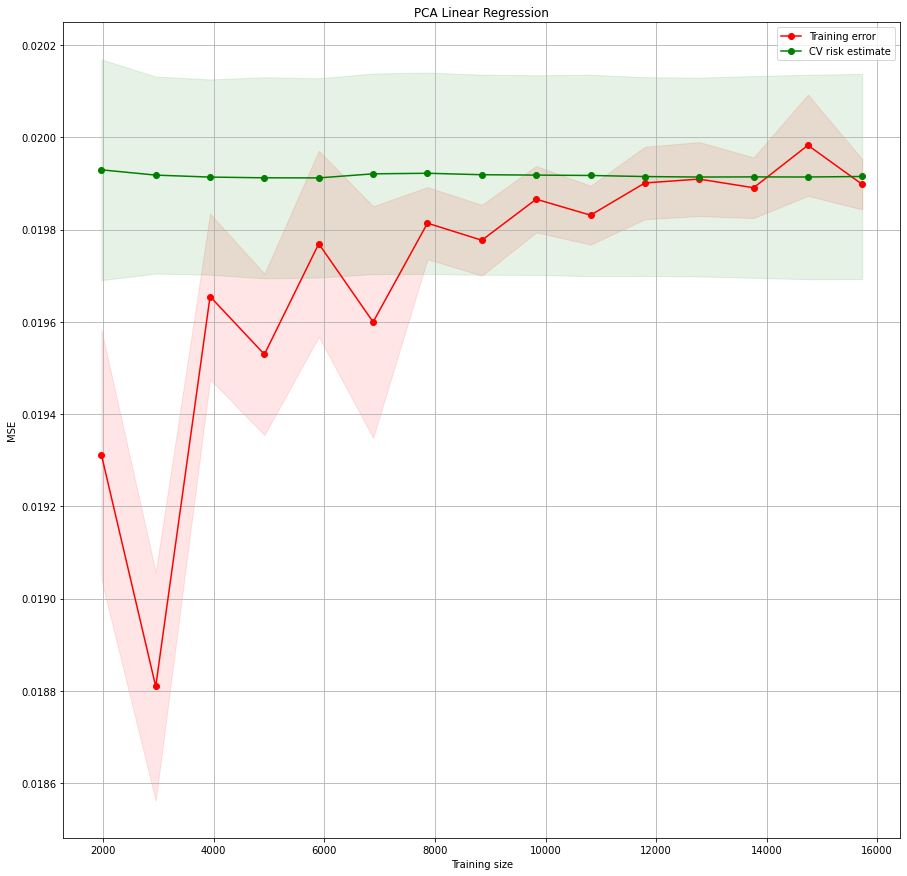

In [52]:
plt.figure(figsize=(15, 15))
plt.title('PCA Linear Regression')

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, alpha=0.1, color="r")
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, alpha=0.1, color="g")

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training error")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="CV risk estimate")

plt.xlabel('Training size')
plt.ylabel(scoring_label)

plt.grid()
plt.legend()
plt.show()

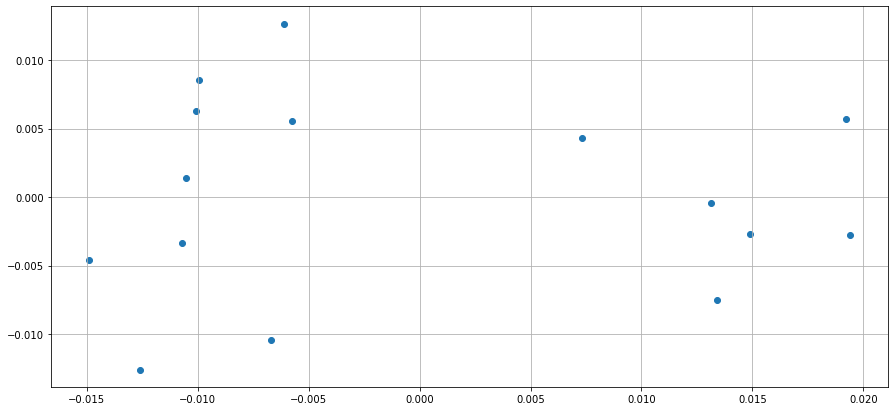

In [53]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, shuffle=shuffleDataSet)
    cholesky.fit(X_train, y_train)
    coef_list.append(cholesky.coef_)
    
coef_matrix = numpy.array(coef_list)

pca = PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

plt.figure(figsize=(15, 7))
plt.grid()
plt.scatter(coef_pca[:,0], coef_pca[:,1])
plt.show()